In [1]:
# Cell 1: Imports & configuration
import os, random, time, math
from pathlib import Path
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print("Device:", device)

# Paths
HR_DIR = Path("train_HR")
LR_DIR = Path("train_LR")
assert HR_DIR.exists() and LR_DIR.exists(), "HR/LR directories must exist."

SCALE = 4
HR_EXPECTED = (1024, 1024)   # UPDATED
PATCH_HR = 128               # still fine; you can raise to 192 or 256 later
PATCH_LR = PATCH_HR // SCALE
BATCH_SIZE = 16
VAL_RATIO = 0.1
EPOCHS = 120
VIRTUAL_PATCHES_PER_EPOCH = 3000
LEARNING_RATE = 1e-3
EDGE_LOSS_WEIGHT = 0.0         # start at 0; add later if needed
EARLY_STOP_PATIENCE = 15
CHECKPOINT_DIR = Path("checkpoints_espcn")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
LOG_FILE = CHECKPOINT_DIR / "train_log.csv"
KEEP_LAST = 3

Device: mps


In [2]:
# Cell 2: Robust paired list + split
VALID_EXT = {".png",".jpg",".jpeg",".bmp",".webp"}

def list_images(folder):
    return [p for p in folder.iterdir() if p.suffix.lower() in VALID_EXT]

hr_files = list_images(HR_DIR)
lr_files = list_images(LR_DIR)
hr_map = {p.stem: p for p in hr_files}
lr_map = {p.stem: p for p in lr_files}

common_keys = sorted(set(hr_map.keys()) & set(lr_map.keys()))
missing_hr = sorted(set(lr_map.keys()) - set(hr_map.keys()))
missing_lr = sorted(set(hr_map.keys()) - set(lr_map.keys()))

if missing_hr:
    print("Warning: LR without HR:", missing_hr[:5], "…")
if missing_lr:
    print("Warning: HR without LR:", missing_lr[:5], "…")

pairs = []
problems = []
for k in common_keys:
    hr_p = hr_map[k]
    lr_p = lr_map[k]
    with Image.open(hr_p) as H, Image.open(lr_p) as L:
        if HR_EXPECTED and H.size != HR_EXPECTED:
            problems.append((hr_p.name, f"HR size {H.size}"))
            continue
        if (H.size[0] != L.size[0]*SCALE) or (H.size[1] != L.size[1]*SCALE):
            problems.append((k, f"scale mismatch HR={H.size} LR={L.size}"))
            continue
    pairs.append((hr_p, lr_p))

print(f"Total common files: {len(common_keys)} | Usable pairs: {len(pairs)} | Problems: {len(problems)}")
if problems[:5]:
    print("Sample problems:", problems[:5])

# Shuffle & split
random.shuffle(pairs)
val_count = max(8, int(len(pairs)*VAL_RATIO))
val_pairs = pairs[:val_count]
train_pairs = pairs[val_count:]
print(f"Train pairs: {len(train_pairs)} | Val pairs: {len(val_pairs)}")

Total common files: 111 | Usable pairs: 111 | Problems: 0
Train pairs: 100 | Val pairs: 11


In [3]:
# Cell 3: Dataset with random aligned patch crops + simple aug (flips)
class SRDataset(Dataset):
    def __init__(self, pairs, scale=4, hr_patch=128, augment=True, y_only=False):
        self.pairs = pairs
        self.scale = scale
        self.hr_patch = hr_patch
        self.lr_patch = hr_patch // scale
        self.augment = augment
        self.y_only = y_only

    def __len__(self):
        return len(self.pairs)

    def _load(self, idx):
        hr_p, lr_p = self.pairs[idx]
        hr = Image.open(hr_p).convert("RGB")
        lr = Image.open(lr_p).convert("RGB")
        return hr, lr, hr_p.name

    def _crop(self, hr, lr):
        w_hr, h_hr = hr.size
        w_lr, h_lr = lr.size
        if self.hr_patch >= w_hr:  # full image fallback
            return hr, lr
        # choose LR coordinate
        x_lr = random.randint(0, w_lr - self.lr_patch)
        y_lr = random.randint(0, h_lr - self.lr_patch)
        x_hr, y_hr = x_lr * self.scale, y_lr * self.scale
        hr_c = hr.crop((x_hr, y_hr, x_hr + self.hr_patch, y_hr + self.hr_patch))
        lr_c = lr.crop((x_lr, y_lr, x_lr + self.lr_patch, y_lr + self.lr_patch))
        return hr_c, lr_c

    def _augment(self, hr, lr):
        if random.random() < 0.5:
            hr = hr.transpose(Image.FLIP_LEFT_RIGHT)
            lr = lr.transpose(Image.FLIP_LEFT_RIGHT)
        if random.random() < 0.5:
            hr = hr.transpose(Image.FLIP_TOP_BOTTOM)
            lr = lr.transpose(Image.FLIP_TOP_BOTTOM)
        return hr, lr

    def _to_tensor(self, img):
        arr = np.array(img).astype("float32")/255.0
        if self.y_only:
            r,g,b = arr[...,0], arr[...,1], arr[...,2]
            y = 0.299*r + 0.587*g + 0.114*b
            arr = y[...,None]
        arr = arr.transpose(2,0,1)
        return torch.from_numpy(arr)

    def __getitem__(self, idx):
        hr, lr, name = self._load(idx)
        hr, lr = self._crop(hr, lr)
        if self.augment:
            hr, lr = self._augment(hr, lr)
        hr_t = self._to_tensor(hr)
        lr_t = self._to_tensor(lr)
        return {"lr": lr_t, "hr": hr_t, "name": name}

train_ds = SRDataset(train_pairs, scale=SCALE, hr_patch=PATCH_HR, augment=True)
val_ds   = SRDataset(val_pairs,   scale=SCALE, hr_patch=HR_EXPECTED[0], augment=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)

batch = next(iter(train_loader))
print("LR shape:", batch["lr"].shape, "HR shape:", batch["hr"].shape)

LR shape: torch.Size([16, 3, 32, 32]) HR shape: torch.Size([16, 3, 128, 128])


In [2]:
# Cell 4: Model (ESPCN variant). Use your espcn_x4 if you trust it; else this.
class ESPCN(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, scale=4, feat=64, hidden=2, activation='prelu', residual_skip=True):
        super().__init__()
        act = {'relu': nn.ReLU(True), 'prelu': nn.PReLU(), 'gelu': nn.GELU()}.get(activation.lower(), nn.PReLU())
        layers = [nn.Conv2d(in_ch, feat, 5, padding=2), act]
        for _ in range(hidden):
            layers += [nn.Conv2d(feat, feat, 3, padding=1), act]
        layers += [nn.Conv2d(feat, out_ch * (scale**2), 3, padding=1)]
        self.body = nn.Sequential(*layers)
        self.ps = nn.PixelShuffle(scale)
        self.residual_skip = residual_skip
        self.scale = scale
        self.out_ch = out_ch
        self.apply(self._init)

    def _init(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        y = self.ps(self.body(x))
        if self.residual_skip:
            up = F.interpolate(x, scale_factor=self.scale, mode='bicubic', align_corners=False)
            if up.shape[1] != self.out_ch:
                up = up[:, :self.out_ch]
            y = y + up
        return y

# If you prefer your external espcn_x4 factory, swap:
# from espcn import espcn_x4
# model = espcn_x4(in_channels=3, out_channels=3, channels=64).to(device)
model = ESPCN(scale=SCALE, feat=64, hidden=2, activation='prelu', residual_skip=True).to(device)
print("Params (M):", sum(p.numel() for p in model.parameters())/1e6)

Params (M): 0.106417


In [5]:
# Cell 5: Loss (Charbonnier instead of pure MSE) + optional edge loss
class CharbonnierLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
    def forward(self, pred, target):
        return torch.mean(torch.sqrt((pred - target)**2 + self.eps))

def to_y(x):
    if x.shape[1] == 1: return x
    r,g,b = x[:,0:1], x[:,1:2], x[:,2:3]
    return 0.299*r + 0.587*g + 0.114*b

def psnr(sr, hr):
    mse = torch.mean((sr - hr)**2)
    if mse.item() == 0:
        return 99.0
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def psnr_y(sr, hr):
    return psnr(to_y(sr), to_y(hr))

# Edge loss (disabled initially)
def sobel_edges(x):
    if x.shape[1] > 1:
        x = to_y(x)
    gx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    gy = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    x_pad = F.pad(x, (1,1,1,1), mode='reflect')
    sx = F.conv2d(x_pad, gx)
    sy = F.conv2d(x_pad, gy)
    return torch.sqrt(sx*sx + sy*sy + 1e-8)

BASE_LOSS = CharbonnierLoss()
def compute_loss(sr, hr):
    base = BASE_LOSS(sr, hr)
    if EDGE_LOSS_WEIGHT > 0:
        base += EDGE_LOSS_WEIGHT * BASE_LOSS(sobel_edges(sr), sobel_edges(hr))
    return base

optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

In [6]:
# Cell 6: Training + validation + logging
if not LOG_FILE.exists():
    with open(LOG_FILE, 'w') as f:
        f.write("epoch,train_loss,val_psnr_y,lr,time\n")

BEST_PSNR = -1.0
epochs_no_improve = 0

def validate():
    model.eval()
    scores = []
    with torch.no_grad():
        for b in val_loader:
            lr_t = b["lr"].to(device)
            hr_t = b["hr"].to(device)
            sr = model(lr_t).clamp(0,1)
            scores.append(psnr_y(sr, hr_t).item())
    return sum(scores)/len(scores)

for epoch in range(1, EPOCHS+1):
    model.train()
    running = 0.0
    steps = 0
    # Virtual epoch: sample random patches
    while steps < VIRTUAL_PATCHES_PER_EPOCH:
        for b in train_loader:
            lr_t = b["lr"].to(device)
            hr_t = b["hr"].to(device)
            sr = model(lr_t)
            loss = compute_loss(sr, hr_t)
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()
            running += loss.item()
            steps += 1
            if steps >= VIRTUAL_PATCHES_PER_EPOCH:
                break
    train_loss = running / steps
    val_psnr = validate()
    scheduler.step(val_psnr)

    lr_now = optimizer.param_groups[0]['lr']
    improved = val_psnr > BEST_PSNR
    tag = "IMPROVED" if improved else ""
    print(f"Epoch {epoch:03d} | train_loss {train_loss:.4f} | val_PSNR(Y) {val_psnr:.2f} dB | lr {lr_now:.3e} {tag}")

    with open(LOG_FILE, 'a') as f:
        f.write(f"{epoch},{train_loss:.6f},{val_psnr:.4f},{lr_now:.6e},{int(time.time())}\n")

    if improved:
        BEST_PSNR = val_psnr
        epochs_no_improve = 0
        ckpt_path = CHECKPOINT_DIR / f"epoch{epoch:03d}_psnr{val_psnr:.2f}.pt"
        torch.save({
            "epoch": epoch,
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "val_psnr_y": val_psnr
        }, ckpt_path)
        # prune
        ckpts = sorted(CHECKPOINT_DIR.glob("epoch*.pt"))
        if len(ckpts) > KEEP_LAST:
            for old in ckpts[:-KEEP_LAST]:
                old.unlink()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= EARLY_STOP_PATIENCE:
            print(f"Early stopping at epoch {epoch}. Best PSNR(Y)={BEST_PSNR:.2f}")
            break

print("Training complete. Best PSNR(Y):", BEST_PSNR)

Epoch 001 | train_loss 0.0316 | val_PSNR(Y) 30.55 dB | lr 1.000e-03 IMPROVED
Epoch 002 | train_loss 0.0276 | val_PSNR(Y) 30.76 dB | lr 1.000e-03 IMPROVED
Epoch 002 | train_loss 0.0276 | val_PSNR(Y) 30.76 dB | lr 1.000e-03 IMPROVED
Epoch 003 | train_loss 0.0262 | val_PSNR(Y) 30.47 dB | lr 1.000e-03 
Epoch 003 | train_loss 0.0262 | val_PSNR(Y) 30.47 dB | lr 1.000e-03 
Epoch 004 | train_loss 0.0258 | val_PSNR(Y) 30.33 dB | lr 1.000e-03 
Epoch 004 | train_loss 0.0258 | val_PSNR(Y) 30.33 dB | lr 1.000e-03 
Epoch 005 | train_loss 0.0253 | val_PSNR(Y) 30.80 dB | lr 1.000e-03 IMPROVED
Epoch 005 | train_loss 0.0253 | val_PSNR(Y) 30.80 dB | lr 1.000e-03 IMPROVED
Epoch 006 | train_loss 0.0251 | val_PSNR(Y) 30.75 dB | lr 1.000e-03 
Epoch 006 | train_loss 0.0251 | val_PSNR(Y) 30.75 dB | lr 1.000e-03 
Epoch 007 | train_loss 0.0247 | val_PSNR(Y) 30.58 dB | lr 1.000e-03 
Epoch 007 | train_loss 0.0247 | val_PSNR(Y) 30.58 dB | lr 1.000e-03 
Epoch 008 | train_loss 0.0245 | val_PSNR(Y) 30.82 dB | lr 1.000

In [4]:
import re

ckpt_dir = CHECKPOINT_DIR  # same dir you used
ckpts = list(ckpt_dir.glob("epoch*_psnr*.pt"))
assert ckpts, "No checkpoints found."

def extract_psnr(p):
    m = re.search(r"psnr([0-9]+(?:\.[0-9]+)?)", p.stem)
    return float(m.group(1)) if m else -1.0

best_ckpt = max(ckpts, key=extract_psnr)
state = torch.load(best_ckpt, map_location='cpu')
model.load_state_dict(state['model'])
print("Loaded best:", best_ckpt.name, "val_PSNR(Y)=", state.get("val_psnr_y"))

# Save consolidated state dict
final_path = ckpt_dir / "espcn_best_state.pth"
torch.save(model.state_dict(), final_path)
print("Saved:", final_path)

# (Optional) full package (state + config)
torch.save({
    "model_state": model.state_dict(),
    "scale": SCALE,
    "patch_hr": PATCH_HR,
    "best_val_psnr_y": state.get("val_psnr_y"),
}, ckpt_dir / "espcn_package.pth")

Loaded best: epoch014_psnr30.98.pt val_PSNR(Y)= 30.984372919256035
Saved: checkpoints_espcn/espcn_best_state.pth


In [5]:
def load_model(weights_path):
    m = ESPCN(scale=SCALE, feat=64, hidden=2, activation='prelu', residual_skip=True)
    m.load_state_dict(torch.load(weights_path, map_location='cpu'))
    m.to(device).eval()
    return m

# If you just saved espcn_best_state.pth
inference_model = load_model(final_path)

def upscale_file(lr_path, out_path):
    img = Image.open(lr_path).convert('RGB')
    arr = np.array(img).astype('float32') / 255.0
    t = torch.from_numpy(arr).permute(2,0,1).unsqueeze(0).to(device)
    with torch.no_grad():
        sr = inference_model(t).clamp(0,1)
    sr_img = (sr[0].permute(1,2,0).cpu().numpy()*255).round().astype('uint8')
    Image.fromarray(sr_img).save(out_path)
    return out_path

# Example
# upscale_file("test_LR/sample.png", "sr_sample.png")

In [6]:
lr_example_path = "train_LR/sak-yant-buffalo-tattoo-design.jpeg"
sr_example_path = "train_SR/sak-yant-buffalo-tattoo-design.jpeg"
# Run super-resolution and capture returned SR path
returned_sr_path = upscale_file(lr_example_path, sr_example_path)
returned_sr_path

'train_SR/sak-yant-buffalo-tattoo-design.jpeg'

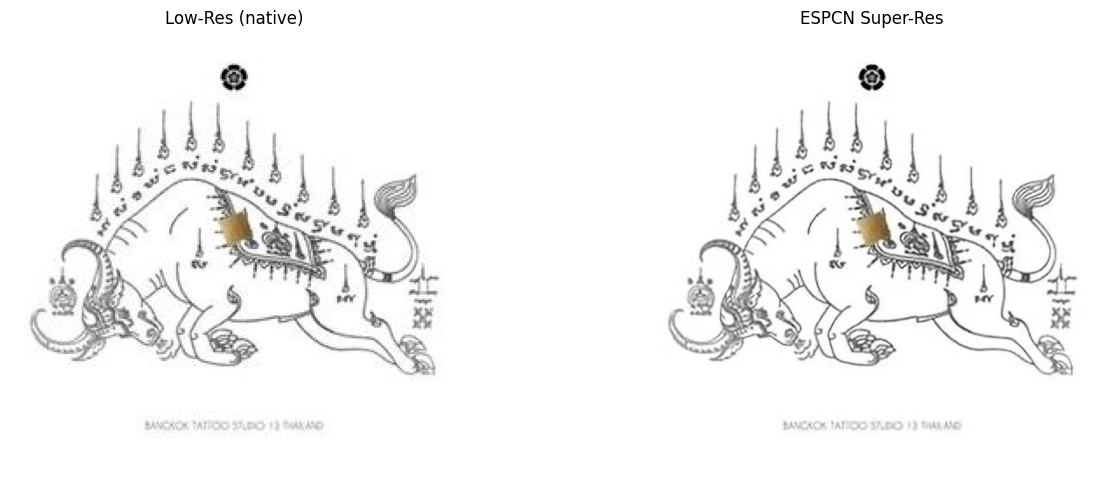

In [8]:
# Side-by-side visualization of LR vs SR
import matplotlib.pyplot as plt
from PIL import Image

# Load images
lr_img = Image.open(lr_example_path).convert('RGB')
sr_img = Image.open(returned_sr_path).convert('RGB')

fig, axes = plt.subplots(1,2, figsize=(14,5))
axes[0].imshow(lr_img)
axes[0].set_title('Low-Res (native)')
axes[0].axis('off')

axes[1].imshow(sr_img)
axes[1].set_title('ESPCN Super-Res')
axes[1].axis('off')

plt.tight_layout()
plt.show()